#### included WOE data and data dictionary

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import importlib
import numpy as np
import lightgbm as lgb

from tqdm import tqdm, tqdm_notebook
import sys

from _utilities import performance_eval as p_eval
from _utilities import performance_eval_v2 as p_eval2
from _utilities import woe

from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 500)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None ## pd warning

### 2 read data

In [21]:
model_df=pd.read_parquet('model_data/model_scoring_df_v1_2.parquet.gzip')
print(model_df.shape)
model_df.head()

(3525526, 95)


,experian_consumer_key,experian_trade_key,actual_infer,thin_thick,observation_ts,y2k_date_open,month_start,y2k_balance_date,y2k_status_date,24_month_bad90_flag,vantage_v3_score,vantage_v4_score,base_ts,premier_v1_2_iqt9427,premier_v1_2_all8320,premier_v1_2_all8151,premier_v1_2_bcc5838,premier_v1_2_iqf9510,premier_v1_2_pil5020,premier_v1_2_pil8120,premier_v1_2_rta7300,premier_v1_2_bcc7700,premier_v1_2_all8558,premier_v1_2_brc7150,premier_v1_2_rev5620,premier_v1_2_bcc7800,premier_v1_2_iqt9420,premier_v1_2_all7116,premier_v1_2_all7936,premier_v1_2_all8160,premier_v1_2_bcc8322,premier_v1_2_brc7180,premier_v1_2_alm6280,premier_v1_2_all3311,premier_v1_2_brc5620,premier_v1_2_iqt9426,premier_v1_2_bcc5620,premier_v1_2_all8552,premier_v1_2_all7938,premier_v1_2_all8325,premier_v1_2_alm6209,premier_v1_2_all0100,premier_v1_2_all7517,premier_v1_2_alm5074,premier_v1_2_all7120,premier_v1_2_iln5400,premier_v1_2_iln5930,premier_v1_2_all8220,premier_v1_2_reh7120,premier_v1_2_iqb9540,premier_v1_2_all7937,premier_v1_2_bcx7110,premier_v1_2_all8259,premier_v1_2_all8257,premier_v1_2_all5072,premier_v1_2_iqt9536,premier_v1_2_pil0438,premier_v1_2_iqt9425,premier_v1_2_all8157,premier_v1_2_iqf9540,premier_v1_2_pil6200,premier_v1_2_all2001,premier_v1_2_all7518,premier_v1_2_alm6200,premier_v1_2_all7519,premier_v1_2_bcc5520,premier_v1_2_all8370,premier_v1_2_all7340,premier_v1_2_all8183,premier_v1_2_all8152,premier_v1_2_als5400,premier_v1_2_all8164,premier_v1_2_rev5742,premier_v1_2_bcc7437,premier_v1_2_iqt9510,premier_v1_2_bca8370,premier_v1_2_all4520,trended3d_tbca2527,trended3d_tbca3631,trended3d_tbca3379,trended3d_tbcc3351,trended3d_tbca3274,trended3d_tbcc2502,trended3d_tbca3282,trended3d_tbcc4260,trended3d_tbcc4210,trended3d_tbca3629,trended3d_tbcc2351,trended3d_tbcc3205,trended3d_tbca3275,trended3d_tbcc4502,trended3d_tbcc2503,trended3d_tbcc3503,vantage_v3,vantage_v4
0,2657036556,52050700964,1,0,2018-10-31,10122016,201610.0,10222018,10012018,0.0,696,782,2016-09-28,1,128,9996,193,9999,999999998,9998,25,54,9996,4,48101,9,1,0,100,9996,143,125,1,0,48101,0,32691,9996,100,9994,1,16,30,0,97,999999998,999999998,398,89,9999,100,51,9996,9996,0,994,98,0,9996,9999,998,96,40,1,40,16575,106,0,9996,9996,417000,9996,0,57,12,135,83,10500,5,69,58,1000,0,88,-6829,3,33,58,7,0,0,0,0,714,779
1,2660312269,52057512577,1,0,2018-10-31,10262016,201610.0,03312018,03012018,0.0,754,799,2016-09-28,5,116,72,27,9999,999999998,9998,13,98,9996,1,24344,4,6,994,100,65,23,1,1,0,24344,0,23744,72,100,65,30,24,25,0,99,27747,999999997,288,16,9999,100,5,9996,9996,0,994,98,0,9996,9999,998,3,50,30,75,12500,53,12,11,65,1230000,9996,0,13,10,53,60,6328,100,21,20,2619,0,25,-3341,11,100,11,7,2619,0,0,0,752,818
2,2688863575,52057137113,1,0,2018-10-31,10302016,201610.0,10122018,10012018,0.0,822,802,2016-09-28,1,115,9996,999999996,9999,999999998,9998,46,88,9996,995,56468,1158,1,0,100,9996,122,995,1,0,56468,0,39368,9996,100,9994,1,25,33,0,4,999999998,999999998,362,4,228,100,1,9996,9996,0,994,98,0,9996,9999,998,96,33,1,44,7940,69,0,9996,9996,25000,9996,0,42,7,95,84,6990,90,6,3,1046,0,29,-5624,10,75,3,7,110,0,0,0,826,802
3,2739472746,52050609947,1,0,2018-10-31,10042016,201610.0,10192018,10012018,0.0,688,672,2016-09-28,3,47,9996,17,9999,999999997,90,40,99,9996,4,6971,5,8,82,100,9996,17,100,1,0,6971,1,3379,9996,100,9994,1,15,20,0,96,27294,525,265,96,41,100,56,9996,9996,0,994,0,1,9996,9999,1,96,80,1,90,1550,35,0,9996,9996,27294,9996,0,83,1,54,84,80,996,96,82,0,0,100,-1532,1,0,73,3,0,0,0,0,662,657
4,2740871560,52082594250,1,0,2018-10-31,10212016,201610.0,10172018,10012018,0.0,623,647,2016-09-28,2,118,2,132,9999,1253,48,0,97,9996,26,405,1,2,994,33,48,66,26,30,0,405,1,405,2,33,48,400,11,33,0,88,22500,284,222,88,9999,33,88,9996,9996,10,994,0,0,9996,9999,1,1,33,30,33,3500,39,29,61,2,85000,9996,0,0,6,50,47,52,8,98,103,403,3,86,-940,1,0,103,5,403,3,1,1,634,625


In [22]:
import re
new_attr_list=[]
orig_attr_list=[]
for attr in model_df.columns:
    if (attr.split("_")[0]=='premier') | (attr.split("_")[0]=='trended3d'):
        new_name=re.split('premier_v1_2_|trended3d_',attr)[1].upper()
        print(attr,new_name)
        model_df[new_name]=model_df[attr]
        new_attr_list.append(new_name)
        orig_attr_list.append(attr)

premier_v1_2_iqt9427 IQT9427
premier_v1_2_all8320 ALL8320
premier_v1_2_all8151 ALL8151
premier_v1_2_bcc5838 BCC5838
premier_v1_2_iqf9510 IQF9510
premier_v1_2_pil5020 PIL5020
premier_v1_2_pil8120 PIL8120
premier_v1_2_rta7300 RTA7300
premier_v1_2_bcc7700 BCC7700
premier_v1_2_all8558 ALL8558
premier_v1_2_brc7150 BRC7150
premier_v1_2_rev5620 REV5620
premier_v1_2_bcc7800 BCC7800
premier_v1_2_iqt9420 IQT9420
premier_v1_2_all7116 ALL7116
premier_v1_2_all7936 ALL7936
premier_v1_2_all8160 ALL8160
premier_v1_2_bcc8322 BCC8322
premier_v1_2_brc7180 BRC7180
premier_v1_2_alm6280 ALM6280
premier_v1_2_all3311 ALL3311
premier_v1_2_brc5620 BRC5620
premier_v1_2_iqt9426 IQT9426
premier_v1_2_bcc5620 BCC5620
premier_v1_2_all8552 ALL8552
premier_v1_2_all7938 ALL7938
premier_v1_2_all8325 ALL8325
premier_v1_2_alm6209 ALM6209
premier_v1_2_all0100 ALL0100
premier_v1_2_all7517 ALL7517
premier_v1_2_alm5074 ALM5074
premier_v1_2_all7120 ALL7120
premier_v1_2_iln5400 ILN5400
premier_v1_2_iln5930 ILN5930
premier_v1_2_a

### 3 scoring

In [23]:
import preprocess_gen1 as preprocess_gen1

def gen1_scoring(df,thin_model,thick_model,id_name=None):
        # Preprocess data    
    base_df = preprocess_gen1.clean(df,thin_model,thick_model,id_name)
    df1=df[['experian_trade_key','ALL8220','ALL0100']]
    
    df1['seg']=np.where( (df1['ALL8220'] <=24 )| (df1['ALL8220'] >9990 )|(df1['ALL0100']<=2 )|(df1['ALL0100']>90), 
                             'thin','thick')
    
    
    base_df=base_df.merge(df1, how='inner',on='experian_trade_key')
    
    
    base_df['thin_pred']=thin_model.predict(base_df[thin_model.feature_name()])
    base_df['thick_pred']=thick_model.predict(base_df[thick_model.feature_name()])
    base_df['model_pred']=np.where(base_df['seg']=='thin', base_df['thin_pred'], base_df['thick_pred'])
    
    factor=40/np.log(2)
    offset=550 - factor*np.log(5)
    base_df['log_odds']=np.log((1-base_df['model_pred'])/base_df['model_pred'])
    base_df['gen1_score']=round(offset+factor*base_df['log_odds'])
    base_df.loc[base_df.gen1_score>850,'gen1_score']=850
    base_df.loc[base_df.gen1_score<300,'gen1_score']=300
        
    
    return base_df

In [24]:
file_name2='./model_results/thin_model_file_v12.p' 
thin_model=pickle.load(open(file_name2,'rb'))

file_name4='./model_results/thick_model_file_v12.p' 
thick_model=pickle.load(open(file_name4,'rb'))

In [25]:
df_gen1_score=gen1_scoring(model_df,thin_model,thick_model,id_name='experian_trade_key')

In [59]:
df_gen1_score.head()

,experian_trade_key,REV5620,TBCC2351,ALL7518,ALM6280,BCA8370,ALL7340,TBCA3282,TBCC2502,BCC7800,TBCA3379,ALL5072,TBCA3629,ALL8325,TBCC3351,REH7120,ALL7120,IQT9425,ALL2001,BRC5620,TBCC4502,TBCA3274,TBCC4210,PIL6200,ALM6200,ALL7517,ALL7936,ALL7519,BRC7150,TBCC3205,ALL4520,IQT9536,IQT9426,TBCC3503,TBCA3631,TBCC2503,IQT9510,BCX7110,ALL8152,IQB9540,TBCA3275,ALM5074,ALM6209,IQF9510,ALL7937,ALL7938,ALL8164,IQT9420,TBCC4260,ALL8160,ALL7116,ALL8320,TBCA2527,BCC5620,IQT9427,ALL8370,ALL8220,ALL0100,seg,thin_pred,thick_pred,model_pred,log_odds,gen1_score
0,52050700964,48101.0,58.0,40.0,1.0,135.0,0.0,88.0,0.0,9.0,69.0,0.0,33.0,NaN,58.0,89.0,97.0,0.0,NaN,48101.0,0.0,1000.0,3.0,NaN,1.0,30.0,100.0,40.0,4.0,7.0,83.0,NaN,0.0,0.0,5.0,0.0,12.0,51.0,NaN,NaN,0.0,0.0,1.0,NaN,100.0,100.0,NaN,1.0,-6829.0,NaN,0.0,128.0,10500.0,32691.0,1.0,106.0,398,16,thick,0.026723,0.013443,0.013443,4.295781,705.0
1,52057512577,24344.0,11.0,50.0,1.0,53.0,12.0,25.0,0.0,4.0,21.0,0.0,100.0,65.0,20.0,16.0,99.0,0.0,3.0,24344.0,0.0,2619.0,11.0,NaN,30.0,25.0,100.0,75.0,1.0,7.0,60.0,NaN,0.0,0.0,100.0,0.0,10.0,5.0,65.0,NaN,2619.0,0.0,30.0,NaN,100.0,100.0,NaN,6.0,-3341.0,65.0,NaN,116.0,6328.0,23744.0,5.0,53.0,288,24,thick,0.011463,0.006512,0.006512,5.027616,747.0
2,52057137113,56468.0,3.0,33.0,1.0,95.0,0.0,29.0,0.0,1158.0,6.0,0.0,75.0,NaN,3.0,4.0,4.0,0.0,NaN,56468.0,0.0,1046.0,10.0,NaN,1.0,33.0,100.0,44.0,NaN,7.0,84.0,NaN,0.0,0.0,90.0,0.0,7.0,1.0,NaN,228.0,110.0,0.0,1.0,NaN,100.0,100.0,NaN,1.0,-5624.0,NaN,0.0,115.0,6990.0,39368.0,1.0,69.0,362,25,thick,0.006880,0.001434,0.001434,6.546194,835.0
3,52050609947,6971.0,73.0,80.0,1.0,54.0,0.0,100.0,0.0,5.0,96.0,0.0,0.0,NaN,82.0,96.0,96.0,1.0,NaN,6971.0,0.0,0.0,1.0,1.0,1.0,20.0,100.0,90.0,4.0,3.0,84.0,NaN,1.0,0.0,NaN,0.0,1.0,56.0,NaN,41.0,0.0,0.0,1.0,NaN,100.0,100.0,NaN,8.0,-1532.0,NaN,82.0,47.0,80.0,3379.0,3.0,35.0,265,15,thick,0.173974,0.103264,0.103264,2.161471,582.0
4,52082594250,405.0,103.0,33.0,30.0,50.0,29.0,86.0,3.0,1.0,98.0,10.0,0.0,48.0,103.0,88.0,88.0,0.0,1.0,405.0,3.0,403.0,1.0,1.0,30.0,33.0,33.0,33.0,26.0,5.0,47.0,NaN,1.0,1.0,8.0,1.0,6.0,88.0,2.0,NaN,403.0,0.0,400.0,NaN,33.0,33.0,NaN,2.0,-940.0,48.0,NaN,118.0,52.0,405.0,2.0,39.0,222,11,thick,0.258228,0.126049,0.126049,1.936354,569.0


In [66]:
model_score_df=df_gen1_score.merge(model_df[['experian_trade_key','vantage_v3','month_start','24_month_bad90_flag']], 
                                   how='inner',on='experian_trade_key')
model_score_df.shape

(3525526, 67)

In [67]:
model_score_df['sam']='train'
model_score_df.loc[(model_score_df.month_start>=201803),'sam']='oot'
model_score_df.loc[(model_score_df.month_start<=201612),'sam']='back'
model_score_df['sam'].value_counts()

model_score_df.loc[model_score_df['vantage_v3']<100,'vantage_v3']=np.nan

In [68]:
model_score_df.groupby(['seg']).size()

seg
thick    3148278
thin      377248
dtype: int64

In [69]:
### thin_train
df_check=model_score_df[(model_score_df.sam=='train')&(model_score_df['seg']=='thin')]
print(len(df_check))
p_eval.model_score_eval(df_check['24_month_bad90_flag'],df_check['gen1_score'],df_check['vantage_v3'],decile=20,display=0)
print()

### thick: train
df_check=model_score_df[(model_score_df.sam=='train')&(model_score_df['seg']=='thick')]
print(len(df_check))
p_eval.model_score_eval(df_check['24_month_bad90_flag'],df_check['gen1_score'],df_check['vantage_v3'],decile=20,display=0)

265602
gen1_score AUC: 0.75733  KS: 37.8
vantage_v3 AUC: 0.69512  KS: 29.2  #score missing: 8600

2222000
gen1_score AUC: 0.83404  KS: 51.1
vantage_v3 AUC: 0.79728  KS: 45.6  #score missing: 41


### 4 pdp files

In [70]:
import pickle
file_name='./model_results/thin_model_pdp_dict.p' 
thin_pdp=pickle.load(open(file_name,'rb'))

In [71]:
import pickle
file_name='./model_results/thick_model_pdp_dict.p' 
thick_pdp=pickle.load(open(file_name,'rb'))

In [72]:
df_test=model_score_df[(model_score_df.sam=='train')]

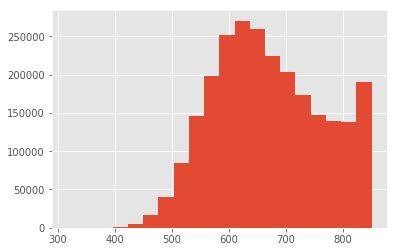

In [73]:
df_test['gen1_score'].hist(bins=20)

In [74]:
df_test['gen1_score'].quantile(0.6)

689.0

In [75]:
aa_df=pd.read_excel('model_data/cc_model_attrs.xlsx',sheet_name='attrs_to_AA')
aa_source=aa_df[['attr','AA_code_valid','AA_code_missing']]
aa_source.head()

,attr,AA_code_valid,AA_code_missing
0,TBCA2527,CC1,V49
1,IQT9420,V85,NaN
2,TBCA3631,CC2,V49
3,ALM6209,V9,V23
4,ALL4520,CC3,V23


In [76]:
aa_source.sort_values(by='attr',inplace=True)
print(len(aa_source))
aa_source.drop_duplicates('attr',keep='first',inplace=True)
print(len(aa_source))

61
55


### test thin 

In [129]:
i=10
attr=['experian_trade_key','vantage_v3','gen1_score']+thin_model.feature_name()
thin_test=df_test[df_test.seg=='thin'][attr]
thin_input=thin_test[i:i+1]
print(thin_input['gen1_score'].values)
thin_input

[557.]


,experian_trade_key,vantage_v3,gen1_score,TBCA2527,IQT9420,TBCA3631,ALL7120,ALM6209,ALL4520,IQT9510,REH7120,BRC5620,TBCA3379,TBCC3351,ALL8370,IQF9510,ALM5074,TBCC2502,ALL7937,ALL2001,IQT9536,TBCA3274,TBCA3282,BCC7800,IQB9540,ALL7116,ALL8152,TBCC4210,PIL6200,BRC7150,IQT9425,TBCA3629,TBCC4260
504963,52137940916,637.0,557.0,NaN,9.0,NaN,81.0,1.0,15.0,10.0,NaN,NaN,NaN,NaN,14.0,NaN,0.0,NaN,100.0,NaN,NaN,NaN,NaN,NaN,310.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [130]:
from _utilities import aa_code
importlib.reload(aa_code)
impact_df,aa_top=aa_code.adverse_action_code(thin_input,thin_pdp,thin_model,aa_source)

In [131]:
impact_df

,attr,pos,value,impact,inq_flag,inq_impact,AA_code_valid,AA_code_missing,aa
0,IQT9420,9.0,9.0,0.022868,1.0,1,V85,NaN,V85
1,REH7120,10000.0,NaN,0.018097,NaN,0,F10,V49,V49
2,TBCA2527,10000.0,NaN,0.011868,NaN,0,CC1,V49,V49
3,TBCA3282,10000.0,NaN,0.009313,NaN,0,CC11,V49,V49
4,TBCC4260,10000.0,NaN,0.005366,NaN,0,CC11,V49,V49
5,TBCA3274,10000.0,NaN,0.003766,NaN,0,CC11,V49,V49
6,TBCA3379,10000.0,NaN,0.002348,NaN,0,CC7,V49,V49
7,TBCA3631,10000.0,NaN,0.001950,NaN,0,CC2,V49,V49
8,BRC7150,10000.0,NaN,0.001125,NaN,0,CC16,V49,V49
9,TBCA3629,10000.0,NaN,0.000969,NaN,0,CC20,V49,V49


In [132]:
aa_top

,attr,pos,value,impact,inq_flag,inq_impact,AA_code_valid,AA_code_missing,aa
0,IQT9420,9.0,9.0,0.022868,1.0,1,V85,NaN,V85
1,REH7120,10000.0,NaN,0.018097,NaN,0,F10,V49,V49
11,ALL7116,10000.0,NaN,0.000446,NaN,0,CC18,V23,V23
12,IQT9536,10000.0,NaN,0.000328,NaN,0,CC13,NaN,NaN


### test thick

In [154]:
attr=['experian_trade_key','vantage_v3','gen1_score']+thick_model.feature_name()
thick_test=df_test[df_test.seg=='thick'][attr]

In [156]:
thick_test['gen1_score'].quantile(0.4)

644.0

In [190]:
i=28
thick_input=thick_test[i:i+1]
print(thick_input['gen1_score'].values)
thick_input

[483.]


,experian_trade_key,vantage_v3,gen1_score,REV5620,TBCA2527,BCC5620,BCA8370,ALL8325,TBCC2351,REH7120,BCX7110,ALL8320,ALL4520,ALL7938,IQT9426,IQT9510,IQT9427,IQT9420,ALL5072,ALL7340,ALL8160,ALL8164,ALL8152,ALL7517,ALL7936,TBCC4502,TBCC3503,TBCC2503,ALM6280,TBCA3275,ALL7519,ALM6200,ALL7518,TBCC3205
504907,623073527,572.0,483.0,249.0,262.0,237.0,26.0,55.0,99.0,106.0,96.0,57.0,84.0,50.0,2.0,2.0,7.0,10.0,4825.0,45.0,21.0,59.0,21.0,57.0,88.0,7.0,4.0,4.0,400.0,0.0,86.0,400.0,86.0,5.0


In [191]:
from _utilities import aa_code
importlib.reload(aa_code)
impact_df,aa_top=aa_code.adverse_action_code(thick_input,thick_pdp,thick_model,aa_source)

In [192]:
impact_df

,attr,pos,value,impact,inq_flag,inq_impact,AA_code_valid,AA_code_missing,aa
0,REH7120,82.0,106.0,0.014714,NaN,0,F10,V49,F10
1,REV5620,4.0,249.0,0.014070,NaN,0,V39,V49,V39
2,TBCC3503,4.0,4.0,0.011876,NaN,0,CC31,V49,CC31
3,TBCA3275,0.0,0.0,0.009558,NaN,0,CC11,V49,CC11
4,TBCC4502,7.0,7.0,0.007330,NaN,0,CC28,V49,CC28
5,ALL7938,5.0,50.0,0.006259,NaN,0,CC24,V23,CC24
6,TBCC2503,4.0,4.0,0.004330,NaN,0,CC14,V49,CC14
7,ALL8320,23.0,57.0,0.004197,NaN,0,CC23,V23,CC23
8,IQT9420,10.0,10.0,0.003910,1.0,0,V85,NaN,V85
9,BCC5620,7.0,237.0,0.003902,NaN,0,V39,V49,V39


In [193]:
aa_top

,attr,pos,value,impact,inq_flag,inq_impact,AA_code_valid,AA_code_missing,aa
0,REH7120,82.0,106.0,0.014714,NaN,0,F10,V49,F10
1,REV5620,4.0,249.0,0.014070,NaN,0,V39,V49,V39
2,TBCC3503,4.0,4.0,0.011876,NaN,0,CC31,V49,CC31
3,TBCA3275,0.0,0.0,0.009558,NaN,0,CC11,V49,CC11


In [195]:
#thick_pdp['REH7120']

In [198]:
file_name='./model_results/aa_source_cc.p' 
pickle.dump(aa_source,open(file_name,'wb'))
len(aa_source)

55

In [200]:
df_out=model_df.merge(df_gen1_score[['experian_trade_key','seg','gen1_score']],
              how='inner',on='experian_trade_key')

In [202]:
df_out.sample(n=200000).to_parquet('model_data/cc_sample.parquet.gzip',compression='gzip')